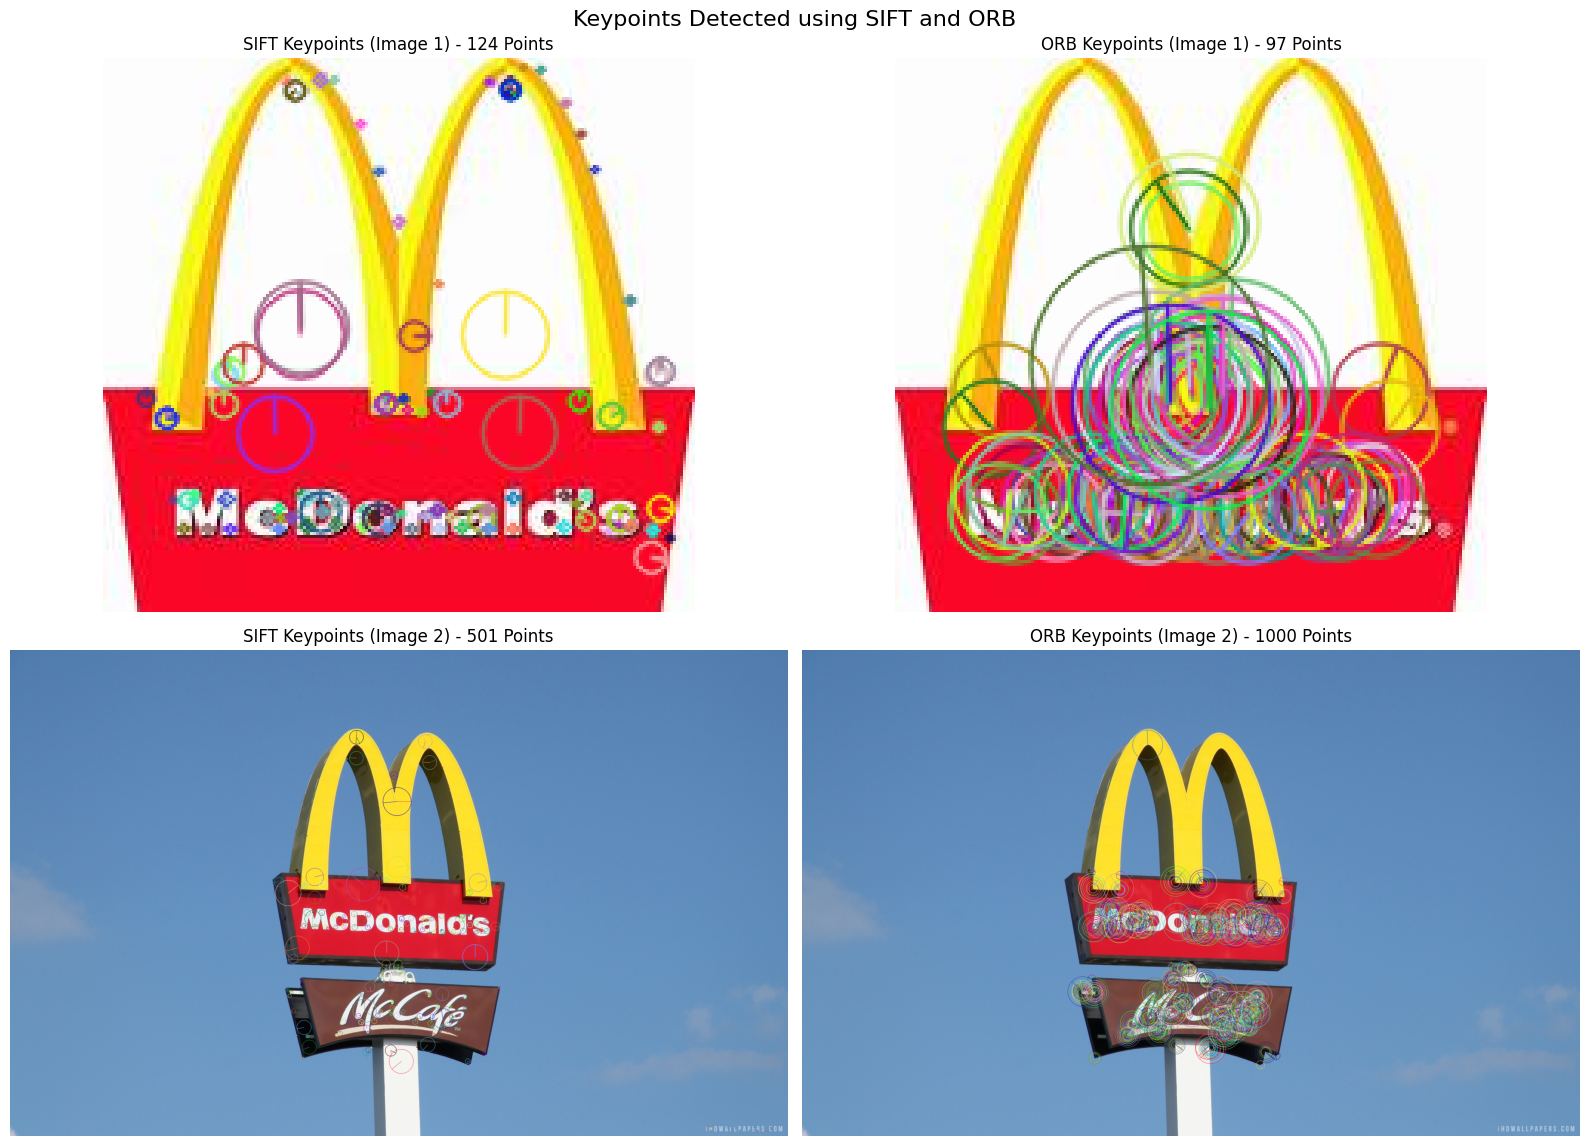

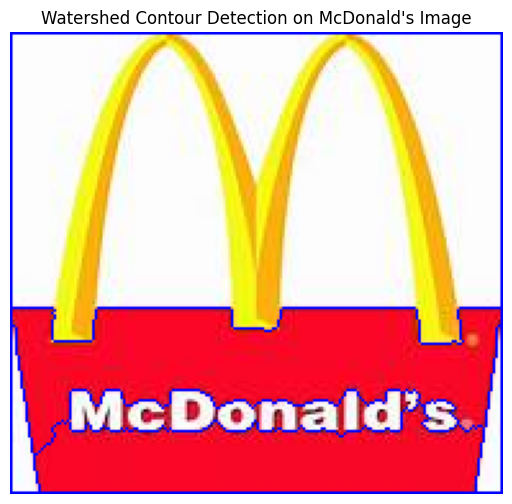

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# === Load and Convert to Grayscale ===
img1 = cv2.imread('/content/mcdonalds.jpeg')  # McDonald's photo
img2 = cv2.imread('/content/mcdonalds_symbol.jpg')  # Logo/symbol

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# === SIFT Keypoints ===
sift = cv2.SIFT_create(nfeatures=500)
kp1_sift, des1_sift = sift.detectAndCompute(gray1, None)
kp2_sift, des2_sift = sift.detectAndCompute(gray2, None)
img1_sift_kp = cv2.drawKeypoints(img1, kp1_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_sift_kp = cv2.drawKeypoints(img2, kp2_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# === ORB Keypoints ===
orb = cv2.ORB_create(nfeatures=1000)
kp1_orb, des1_orb = orb.detectAndCompute(gray1, None)
kp2_orb, des2_orb = orb.detectAndCompute(gray2, None)
img1_orb_kp = cv2.drawKeypoints(img1, kp1_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_orb_kp = cv2.drawKeypoints(img2, kp2_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# === SIFT Matching (L2 + Ratio Test) ===
bf_sift = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches_sift = bf_sift.knnMatch(des1_sift, des2_sift, k=2)
good_sift = [m for m, n in matches_sift if m.distance < 0.75 * n.distance]
img_sift_match = cv2.drawMatches(img1, kp1_sift, img2, kp2_sift, good_sift[:30], None, flags=2)

# === ORB Matching (Hamming + CrossCheck) ===
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches_orb = bf_orb.match(des1_orb, des2_orb)
matches_orb = sorted(matches_orb, key=lambda x: x.distance)
img_orb_match = cv2.drawMatches(img1, kp1_orb, img2, kp2_orb, matches_orb[:30], None, flags=2)

# === Watershed Segmentation for Contours ===
img_ws = img1.copy()
gray = cv2.cvtColor(img_ws, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3, 3), np.uint8)

opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(img_ws, markers)
img_ws[markers == -1] = [255, 0, 0]  # Mark watershed boundaries in red

# === Display: Keypoints ===
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs[0, 0].imshow(cv2.cvtColor(img1_sift_kp, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title(f"SIFT Keypoints (Image 1) - {len(kp1_sift)} Points")
axs[0, 0].axis('off')

axs[0, 1].imshow(cv2.cvtColor(img1_orb_kp, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title(f"ORB Keypoints (Image 1) - {len(kp1_orb)} Points")
axs[0, 1].axis('off')

axs[1, 0].imshow(cv2.cvtColor(img2_sift_kp, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title(f"SIFT Keypoints (Image 2) - {len(kp2_sift)} Points")
axs[1, 0].axis('off')

axs[1, 1].imshow(cv2.cvtColor(img2_orb_kp, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title(f"ORB Keypoints (Image 2) - {len(kp2_orb)} Points")
axs[1, 1].axis('off')

plt.suptitle("Keypoints Detected using SIFT and ORB", fontsize=16)
plt.tight_layout()
plt.show()

# === Display: Matches ===
fig, axs = plt.subplots(2, 1, figsize=(16, 10))
axs[0].imshow(cv2.cvtColor(img_sift_match, cv2.COLOR_BGR2RGB))
axs[0].set_title(f"SIFT Matching - Good Matches: {len(good_sift)}")
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(img_orb_match, cv2.COLOR_BGR2RGB))
axs[1].set_title("ORB Matching - Top 30 Matches")
axs[1].axis('off')

plt.suptitle("Feature Matching: SIFT vs ORB", fontsize=16)
plt.tight_layout()
plt.show()

# === Display: Watershed Segmentation ===
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_ws, cv2.COLOR_BGR2RGB))
plt.title("Watershed Contour Detection on McDonald's Image")
plt.axis('off')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

def load_datasets():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])

    train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

def get_resnet_model(version=18, num_classes=100):
    if version == 18:
        model = models.resnet18(pretrained=False)
    elif version == 34:
        model = models.resnet34(pretrained=False)
    else:
        raise ValueError("Unsupported ResNet version")

    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

def train_model(model, train_loader, test_loader, epochs=25, model_name='resnet'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    inference_times = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        scheduler.step()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        test_loss, test_acc, inf_time = evaluate_model(model, test_loader, criterion)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        inference_times.append(inf_time)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, '
              f'Inference Time: {inf_time:.4f}s')

    stats = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'inference_times': inference_times
    }

    return stats

def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    inference_time = time.time() - start_time
    avg_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy, inference_time


def plot_training_curves(stats1, stats2, label1='ResNet-18', label2='ResNet-34'):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(stats1['train_accs'], label=f'{label1} Train')
    plt.plot(stats1['test_accs'], label=f'{label1} Test')
    plt.plot(stats2['train_accs'], label=f'{label2} Train')
    plt.plot(stats2['test_accs'], label=f'{label2} Test')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(stats1['train_losses'], label=f'{label1} Train')
    plt.plot(stats1['test_losses'], label=f'{label1} Test')
    plt.plot(stats2['train_losses'], label=f'{label2} Train')
    plt.plot(stats2['test_losses'], label=f'{label2} Test')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def compare_models(stats1, stats2, model1, model2, name1='ResNet-18', name2='ResNet-34'):
    comparison = {
        'Model': [name1, name2],
        'Best Train Acc (%)': [max(stats1['train_accs']), max(stats2['train_accs'])],
        'Best Test Acc (%)': [max(stats1['test_accs']), max(stats2['test_accs'])],
        'Final Train Loss': [stats1['train_losses'][-1], stats2['train_losses'][-1]],
        'Final Test Loss': [stats1['test_losses'][-1], stats2['test_losses'][-1]],
        'Avg Inference Time (s)': [np.mean(stats1['inference_times']), np.mean(stats2['inference_times'])],
        'Parameters': [sum(p.numel() for p in model1.parameters()),
                      sum(p.numel() for p in model2.parameters())]
    }

    # Create a table
    print("\nModel Comparison:")
    print("{:<15} {:<18} {:<18} {:<18} {:<18} {:<22} {:<15}".format(
        'Model', 'Best Train Acc', 'Best Test Acc', 'Final Train Loss',
        'Final Test Loss', 'Avg Inference Time', 'Parameters'))

    for i in range(2):
        print("{:<15} {:<18.2f} {:<18.2f} {:<18.4f} {:<18.4f} {:<22.4f} {:<15,}".format(
            comparison['Model'][i],
            comparison['Best Train Acc (%)'][i],
            comparison['Best Test Acc (%)'][i],
            comparison['Final Train Loss'][i],
            comparison['Final Test Loss'][i],
            comparison['Avg Inference Time (s)'][i],
            comparison['Parameters'][i]))

if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_loader, test_loader = load_datasets()

    resnet18 = get_resnet_model(version=18).to(device)
    resnet34 = get_resnet_model(version=34).to(device)

    print("\nResNet-18 Summary:")
    summary(resnet18, (3, 32, 32))
    print("\nResNet-34 Summary:")
    summary(resnet34, (3, 32, 32))

    epochs = 5

    print("\nTraining ResNet-18...")
    resnet18_stats = train_model(resnet18, train_loader, test_loader, epochs, 'resnet18')

    print("\nTraining ResNet-34...")
    resnet34_stats = train_model(resnet34, train_loader, test_loader, epochs, 'resnet34')

    plot_training_curves(resnet18_stats, resnet34_stats)

    compare_models(resnet18_stats, resnet34_stats, resnet18, resnet34)

Using device: cuda


100%|██████████| 169M/169M [00:13<00:00, 12.2MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



ResNet-18 Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
          Identity-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-1

Epoch 1/5: 100%|██████████| 391/391 [00:40<00:00,  9.57it/s]


Epoch 1: Train Loss: 3.9427, Train Acc: 9.18%, Test Loss: 3.6140, Test Acc: 13.78%, Inference Time: 2.9079s


Epoch 2/5: 100%|██████████| 391/391 [00:40<00:00,  9.55it/s]


Epoch 2: Train Loss: 3.2729, Train Acc: 19.60%, Test Loss: 3.0624, Test Acc: 24.12%, Inference Time: 2.9145s


Epoch 3/5: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s]


Epoch 3: Train Loss: 2.6650, Train Acc: 31.34%, Test Loss: 2.5290, Test Acc: 33.38%, Inference Time: 3.3075s


Epoch 4/5: 100%|██████████| 391/391 [00:43<00:00,  9.07it/s]


Epoch 4: Train Loss: 2.1251, Train Acc: 42.54%, Test Loss: 2.1044, Test Acc: 43.84%, Inference Time: 3.0541s


Epoch 5/5: 100%|██████████| 391/391 [00:42<00:00,  9.13it/s]


Epoch 5: Train Loss: 1.7411, Train Acc: 52.01%, Test Loss: 1.7718, Test Acc: 51.03%, Inference Time: 3.1422s

Training ResNet-34...


Epoch 1/5: 100%|██████████| 391/391 [01:13<00:00,  5.33it/s]


Epoch 1: Train Loss: 4.1657, Train Acc: 6.12%, Test Loss: 3.7817, Test Acc: 10.50%, Inference Time: 4.8763s


Epoch 2/5: 100%|██████████| 391/391 [01:11<00:00,  5.44it/s]


Epoch 2: Train Loss: 3.5458, Train Acc: 14.80%, Test Loss: 3.4005, Test Acc: 18.12%, Inference Time: 5.3693s


Epoch 3/5: 100%|██████████| 391/391 [01:12<00:00,  5.43it/s]


Epoch 3: Train Loss: 3.0536, Train Acc: 23.71%, Test Loss: 2.9113, Test Acc: 27.08%, Inference Time: 5.0160s


Epoch 4/5: 100%|██████████| 391/391 [01:11<00:00,  5.43it/s]


Epoch 4: Train Loss: 2.5609, Train Acc: 33.34%, Test Loss: 2.4117, Test Acc: 36.82%, Inference Time: 5.1163s


Epoch 5/5: 100%|██████████| 391/391 [01:11<00:00,  5.44it/s]


Epoch 5: Train Loss: 2.0956, Train Acc: 43.24%, Test Loss: 2.0641, Test Acc: 44.40%, Inference Time: 4.8929s



Model Comparison:
Model           Best Train Acc     Best Test Acc      Final Train Loss   Final Test Loss    Avg Inference Time     Parameters     
ResNet-18       52.01              51.03              1.7411             1.7718             3.0652                 11,220,132     
ResNet-34       43.24              44.40              2.0956             2.0641             5.0542                 21,328,292     


100%|██████████| 9.91M/9.91M [00:11<00:00, 900kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.25MB/s]


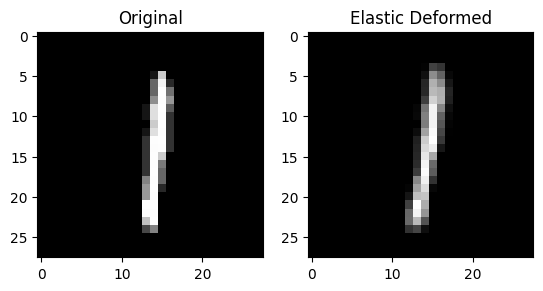

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),  # scales to [0,1]
])

from scipy.ndimage import gaussian_filter, map_coordinates
import random

def elastic_deformation(image, alpha=36, sigma=6):
    image = image.squeeze().numpy()  # (1, 28, 28) → (28, 28)
    random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    distorted = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    return torch.tensor(distorted).unsqueeze(0)

# Load dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split dataset: 80% train, 20% test
train_size = int(0.8 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size
train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size])

# Optional: Apply elastic deformation to samples (example)
def augment_with_elastic(dataset, num_samples=1000):
    augmented_images = []
    augmented_labels = []

    for i in range(num_samples):
        img, label = dataset[i]
        deformed = elastic_deformation(img)
        augmented_images.append((deformed, label))

    return augmented_images

# Example usage
augmented_samples = augment_with_elastic(train_dataset, num_samples=1000)

# Show a sample
fig, axs = plt.subplots(1, 2)
sample_img, _ = train_dataset[0]
deformed_img = elastic_deformation(sample_img)

axs[0].imshow(sample_img.squeeze(), cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(deformed_img.squeeze(), cmap='gray')
axs[1].set_title("Elastic Deformed")
plt.show()



In [ ]:
from collections import defaultdict
from torchvision.datasets import MNIST

def create_classwise_dict(dataset):
    classwise_data = defaultdict(list)
    for img, label in dataset:
        classwise_data[label].append(img)
    return classwise_data

import random

def create_episode(classwise_data, N=5, K=1, Q=1):
    """
    Create a single N-way K-shot episode with Q query samples per class.
    """
    selected_classes = random.sample(list(classwise_data.keys()), N)

    support_images = []
    support_labels = []
    query_images = []
    query_labels = []

    label_map = {cls: idx for idx, cls in enumerate(selected_classes)}

    for cls in selected_classes:
        samples = random.sample(classwise_data[cls], K + Q)
        support = samples[:K]
        query = samples[K:]

        support_images.extend(support)
        support_labels.extend([label_map[cls]] * K)
        query_images.extend(query)
        query_labels.extend([label_map[cls]] * Q)

    return (support_images, support_labels), (query_images, query_labels)

def compute_accuracy(preds, labels):
    correct = sum([p == l for p, l in zip(preds, labels)])
    return correct / len(labels)

# Step 1: Organize training data by class
classwise_train_data = create_classwise_dict(train_dataset)

# Step 2: Generate an episode
(support_imgs, support_lbls), (query_imgs, query_lbls) = create_episode(classwise_train_data, N=5, K=1, Q=3)

# Step 3: Visualize a few support and query images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axs[0][i].imshow(support_imgs[i].squeeze(), cmap='gray')
    axs[0][i].set_title(f"Support: {support_lbls[i]}")
    axs[1][i].imshow(query_imgs[i].squeeze(), cmap='gray')
    axs[1][i].set_title(f"Query: {query_lbls[i]}")
    axs[0][i].axis('off')
    axs[1][i].axis('off')
plt.show()



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score

# Common Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --------------------------------------------
# 3.1 Prototypical Network
# --------------------------------------------
class ProtoNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten()
        )

    def forward(self, x):
        return self.encoder(x)

def compute_prototypes(embeddings, labels, N):
    prototypes = []
    for i in range(N):
        cls_embeds = embeddings[labels == i]
        prototype = cls_embeds.mean(dim=0)
        prototypes.append(prototype)
    return torch.stack(prototypes)

def euclidean_distance(a, b):
    return torch.cdist(a, b, p=2)

def create_episode(classwise_data, N, K, Q):
    selected_classes = random.sample(list(classwise_data.keys()), N)
    support_imgs, query_imgs = [], []
    support_lbls, query_lbls = [], []
    for i, cls in enumerate(selected_classes):
        imgs = random.sample(classwise_data[cls], K + Q)
        support_imgs += imgs[:K]
        query_imgs += imgs[K:]
        support_lbls += [i]*K
        query_lbls += [i]*Q
    return (support_imgs, support_lbls), (query_imgs, query_lbls)

def train_protonet(model, classwise_data, episodes=1000, N=5, K=1, Q=5, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for episode in range(episodes):
        (support_imgs, support_lbls), (query_imgs, query_lbls) = create_episode(classwise_data, N, K, Q)
        support = torch.stack([transform(img) for img in support_imgs]).to(device)
        query = torch.stack([transform(img) for img in query_imgs]).to(device)
        support_lbls = torch.tensor(support_lbls, dtype=torch.long).to(device)
        query_lbls = torch.tensor(query_lbls, dtype=torch.long).to(device)

        support_embed = model(support)
        query_embed = model(query)
        prototypes = compute_prototypes(support_embed, support_lbls, N)

        dists = euclidean_distance(query_embed, prototypes)
        logits = -dists  # More negative = more similar
        loss = loss_fn(logits, query_lbls)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (episode + 1) % 100 == 0:
            preds = torch.argmin(dists, dim=1)
            acc = (preds == query_lbls).float().mean().item()
            print(f"[ProtoNet] Episode {episode+1}, Loss: {loss.item():.4f}, Acc: {acc:.4f}")

def evaluate_protonet(model, classwise_data, N=5, K=1, Q=5, episodes=100, device='cuda'):
    model.to(device)
    model.eval()
    accs = []

    with torch.no_grad():
        for _ in range(episodes):
            (support_imgs, support_lbls), (query_imgs, query_lbls) = create_episode(classwise_data, N, K, Q)
            support = torch.stack([transform(img) for img in support_imgs]).to(device)
            query = torch.stack([transform(img) for img in query_imgs]).to(device)
            support_lbls = torch.tensor(support_lbls).to(device)
            query_lbls = torch.tensor(query_lbls).to(device)

            support_embed = model(support)
            query_embed = model(query)
            prototypes = compute_prototypes(support_embed, support_lbls, N)
            dists = euclidean_distance(query_embed, prototypes)
            preds = torch.argmin(dists, dim=1)
            accs.append((preds == query_lbls).float().mean().item())

    print(f"[ProtoNet Eval] Avg Accuracy: {np.mean(accs):.4f}")

# --------------------------------------------
# 3.2 Siamese Network
# --------------------------------------------
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

    def forward_once(self, x):
        return self.encoder(x)

    def forward(self, x1, x2):
        return self.forward_once(x1), self.forward_once(x2)

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        dist = F.pairwise_distance(output1, output2)
        loss = 0.5 * (label * dist.pow(2) + (1 - label) * (F.relu(self.margin - dist).pow(2)))
        return loss.mean()

def make_pairs(data):
    pairs, labels = [], []
    label_dict = defaultdict(list)
    for img, lbl in data:
        label_dict[lbl].append(img)

    labels_list = list(label_dict.keys())
    for label in labels_list:
        imgs = label_dict[label]
        for i in range(len(imgs)-1):
            pairs.append([transform(imgs[i]), transform(imgs[i+1])])
            labels.append(1.0)
            neg_label = random.choice([l for l in labels_list if l != label])
            pairs.append([transform(imgs[i]), transform(label_dict[neg_label][0])])
            labels.append(0.0)
    return pairs, labels

class SiameseDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __getitem__(self, index):
        x1, x2 = self.pairs[index]
        y = torch.tensor(self.labels[index], dtype=torch.float32)
        return x1, x2, y

    def __len__(self):
        return len(self.pairs)

def train_siamese(model, loader, optimizer, criterion, device, epochs=5):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x1, x2, y in loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            out1, out2 = model(x1, x2)
            loss = criterion(out1, out2, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Siamese] Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")

def evaluate_siamese(model, loader, device, threshold=0.5):
    model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x1, x2, y in loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            out1, out2 = model(x1, x2)
            dist = F.pairwise_distance(out1, out2)
            preds = (dist < threshold).float()
            correct += (preds == y).sum().item()
            total += y.size(0)
    print(f"[Siamese Eval] Accuracy: {correct / total:.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from collections import defaultdict
import random
import numpy as np

# Matching Network Encoder
class MatchingEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

# Cosine similarity classifier
def cosine_similarity_classifier(q_embed, s_embed, s_labels, N):
    sims = F.cosine_similarity(q_embed.unsqueeze(1), s_embed.unsqueeze(0), dim=2)
    weights = F.softmax(sims, dim=1)
    one_hot = F.one_hot(s_labels, num_classes=N).float()
    probs = torch.matmul(weights, one_hot)
    return torch.argmax(probs, dim=1)

# Create one-shot pairs (support + query)
def create_one_shot_task(data, N=5, K=1):
    classes = random.sample(list(data.keys()), N)
    support_images, support_labels = [], []
    query_images, query_labels = [], []
    for idx, cls in enumerate(classes):
        samples = random.sample(data[cls], K + 1)
        support_images.extend(samples[:K])
        support_labels.extend([idx] * K)
        query_images.append(samples[-1])
        query_labels.append(idx)
    return (support_images, support_labels), (query_images, query_labels)

# Training the Matching Network
def train_matching_net(model, data, epochs=300, N=5, K=1, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    transform = transforms.ToTensor()

    for ep in range(epochs):
        (s_imgs, s_lbls), (q_imgs, q_lbls) = create_one_shot_task(data, N, K)
        s = torch.stack([transform(img) for img in s_imgs]).to(device)
        q = torch.stack([transform(img) for img in q_imgs]).to(device)
        s_lbls = torch.tensor(s_lbls).to(device)
        q_lbls = torch.tensor(q_lbls).to(device)

        s_embed = model(s)
        q_embed = model(q)
        sims = F.cosine_similarity(q_embed.unsqueeze(1), s_embed.unsqueeze(0), dim=2)
        loss = loss_fn(sims, q_lbls)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (ep + 1) % 50 == 0:
            preds = cosine_similarity_classifier(q_embed, s_embed, s_lbls, N)
            acc = (preds == q_lbls).float().mean().item()
            print(f"[{ep+1}/{epochs}] Loss: {loss.item():.4f}, Acc: {acc:.4f}")

# Dataset organization
def build_classwise_data():
    mnist = datasets.MNIST(root='./data', train=True, download=True)
    classwise_data = defaultdict(list)
    for img, label in mnist:
        classwise_data[label].append(img)
    return classwise_data

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classwise_data = build_classwise_data()
model = MatchingEncoder()
train_matching_net(model, classwise_data, epochs=300, N=5, K=1, device=device)


[50/300] Loss: 1.4732, Acc: 0.4000
[100/300] Loss: 1.4326, Acc: 0.4000
[150/300] Loss: 1.3258, Acc: 0.6000
[200/300] Loss: 1.4197, Acc: 0.6000
[250/300] Loss: 1.4695, Acc: 0.6000
[300/300] Loss: 1.3123, Acc: 0.8000


In [ ]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward_once(self, x):
        x = self.cnn(x)
        return self.fc(x.view(x.size(0), -1))

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return F.pairwise_distance(out1, out2)

# Create pairs with labels (same class => 1, different => 0)
def create_siamese_pairs(data, num_pairs=1000):
    pairs = []
    labels = []
    transform = transforms.ToTensor()
    classes = list(data.keys())
    for _ in range(num_pairs):
        # Same class
        cls = random.choice(classes)
        img1, img2 = random.sample(data[cls], 2)
        pairs.append((transform(img1), transform(img2)))
        labels.append(1)

        # Different class
        cls1, cls2 = random.sample(classes, 2)
        img1 = random.choice(data[cls1])
        img2 = random.choice(data[cls2])
        pairs.append((transform(img1), transform(img2)))
        labels.append(0)
    return pairs, labels

# Train Siamese Model
def train_siamese(model, data, device='cuda', epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        pairs, labels = create_siamese_pairs(data)
        x1 = torch.stack([p[0] for p in pairs]).to(device)
        x2 = torch.stack([p[1] for p in pairs]).to(device)
        lbls = torch.tensor(labels, dtype=torch.float32).to(device)

        out = model(x1, x2)
        loss = loss_fn(-out, lbls)  # use -dist for BCE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"[{epoch+1}/{epochs}] Siamese Loss: {loss.item():.4f}")

# Run training
siamese_model = SiameseNet()
train_siamese(siamese_model, classwise_data, device=device, epochs=10)


[1/10] Siamese Loss: 0.6896
[2/10] Siamese Loss: 0.6769
[3/10] Siamese Loss: 0.6604
[4/10] Siamese Loss: 0.6512
[5/10] Siamese Loss: 0.6485
[6/10] Siamese Loss: 0.6369
[7/10] Siamese Loss: 0.6319
[8/10] Siamese Loss: 0.6358
[9/10] Siamese Loss: 0.6256
[10/10] Siamese Loss: 0.6285


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return acc, prec, rec, f1

def print_metrics(name, acc, prec, rec, f1):
    print(f"\n--- {name} Performance ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")

def evaluate_matching(model, data, N=5, K=1, num_tasks=100, device='cuda'):
    model.eval()
    transform = transforms.ToTensor()
    all_preds, all_labels = [], []

    for _ in range(num_tasks):
        (s_imgs, s_lbls), (q_imgs, q_lbls) = create_one_shot_task(data, N, K)
        s = torch.stack([transform(img) for img in s_imgs]).to(device)
        q = torch.stack([transform(img) for img in q_imgs]).to(device)
        s_lbls = torch.tensor(s_lbls).to(device)
        q_lbls = torch.tensor(q_lbls).to(device)

        s_embed = model(s)
        q_embed = model(q)
        preds = cosine_similarity_classifier(q_embed, s_embed, s_lbls, N)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(q_lbls.cpu().numpy())

    return evaluate_metrics(all_labels, all_preds)

def evaluate_siamese(model, data, num_pairs=1000, device='cuda'):
    model.eval()
    transform = transforms.ToTensor()
    pairs, labels = create_siamese_pairs(data, num_pairs=num_pairs)

    x1 = torch.stack([p[0] for p in pairs]).to(device)
    x2 = torch.stack([p[1] for p in pairs]).to(device)
    y_true = torch.tensor(labels).cpu().numpy()

    with torch.no_grad():
        distances = model(x1, x2).cpu()
    y_pred = (distances < 1.0).int().numpy()  # Threshold can be adjusted

    return evaluate_metrics(y_true, y_pred)

# Run evaluation for both models
matching_acc, matching_prec, matching_rec, matching_f1 = evaluate_matching(model, classwise_data)
print_metrics("Matching Network", matching_acc, matching_prec, matching_rec, matching_f1)

siamese_acc, siamese_prec, siamese_rec, siamese_f1 = evaluate_siamese(siamese_model, classwise_data)
print_metrics("Siamese Network", siamese_acc, siamese_prec, siamese_rec, siamese_f1)

def reduce_training_data(data, max_per_class=20):
    new_data = defaultdict(list)
    for cls in data:
        new_data[cls] = data[cls][:max_per_class]
    return new_data

# Compare performance with reduced data
reduced_data = reduce_training_data(classwise_data, max_per_class=10)
matching_acc_r, _, _, _ = evaluate_matching(model, reduced_data)
print(f"\nMatching Network with less data - Accuracy: {matching_acc_r:.4f}")



--- Matching Network Performance ---
Accuracy:  0.6480
Precision: 0.6506
Recall:    0.6480
F1-Score:  0.6478

--- Siamese Network Performance ---
Accuracy:  0.7070
Precision: 0.7958
Recall:    0.7070
F1-Score:  0.6832

Matching Network with less data - Accuracy: 0.6440
